# 🧠 Machine Learning & Deep Learning for Microbiome and Multi-omics Data
### Training Hands-on Session
**Date:** _2025-10-21_  
**Author:** _Berkay Ekren_  
**Session:** Hands-On

##### Required Packages
1. Python >3.12


## 🕐 Hands-on Session 1: Machine Learning for Microbiome and Multi-omics Case Studies
### 📋 Objectives:
- Perform **classification** or **regression** using microbiome and omics datasets.
- Identify **biomarkers** relevant to aquaculture species.

### 🔗 Suggested Datasets:
- Microbiome OTU/ASV tables
- Metabolomics or transcriptomics profiles
- Aquaculture phenotype or environmental metadata

### 🧰 Tasks:
1. Load and preprocess data
2. Explore dataset (summary statistics, visualization)
3. Early integration - Late integration methods
4. Apply ML models (e.g., Random Forest, SVM, Gradient Boosting)
5. Evaluate model performances
6. Identify potential biomarkers (feature importance, SHAP, etc.)

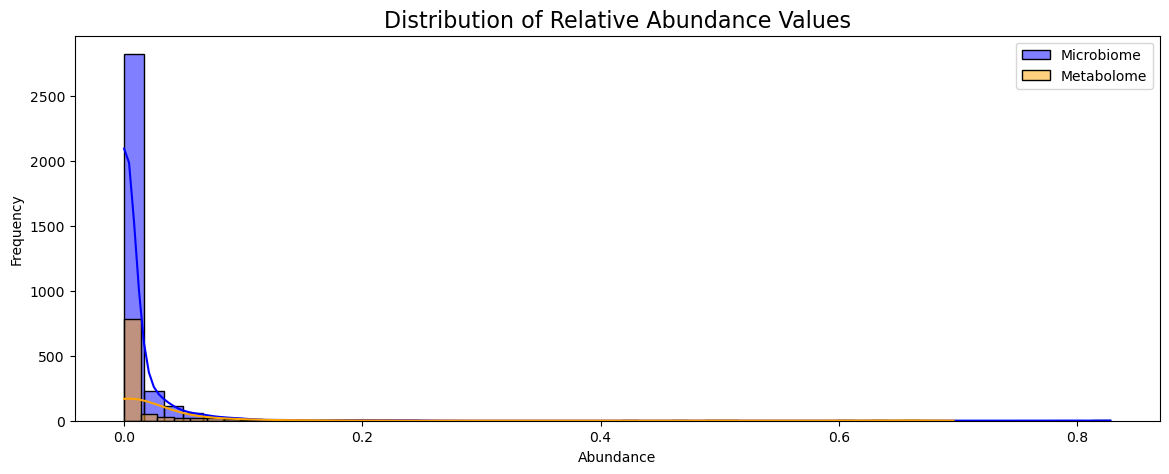

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the medatada
metadata_df = pd.read_csv("data/metadata.csv", sep="\t")

# Import data [1]
microbiome_df = pd.read_csv("data/microbiome.csv", sep="\t")
metabolome_df = pd.read_csv("data/metabolome.csv", sep="\t")

# Uncomment the below 2 lines to see the first few rows of the dataframes to see the file structure
#print(microbiome_df.head())
#print(metabolome_df.head())

# Check the distribution of the data with histograms
plt.figure(figsize=(14, 5))
sns.histplot(microbiome_df.iloc[:, 1:].values.flatten(), bins=50, color='blue', label='Microbiome', kde=True)
sns.histplot(metabolome_df.iloc[:, 1:].values.flatten(), bins=50, color='orange', label='Metabolome', kde=True)
plt.title('Distribution of Relative Abundance Values', fontsize=16)
plt.xlabel('Abundance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [24]:
# Import necessary libraries
import numpy as np
# from sklearn.feature_selection import SelectFromModel # Uncomment if using SelectFromModel
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

#### 🧬 Early integration in machine learning: Concatanate features before modelling

In [14]:
print("--- Strategy 1: Early Integration ---")

# 1. Set the first column as the index for each dataframe
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# 2. Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

# 3. Concatenate the dataframes horizontally (axis=1) to create a single feature matrix.
# This aligns the data by sample ID (the index).
early_integration_df = pd.concat([X_microbiome, X_metabolome], axis=1)

print("Shape of Microbiome data (samples, features):", X_microbiome.shape)
print("Shape of Metabolome data (samples, features):", X_metabolome.shape)
print("Shape of combined data for Early Integration:", early_integration_df.shape)

print("\n--- Early Integration DataFrame Head ---")
print(early_integration_df.head(2))

# --- Create target variables (y) from metadata ---
# 4. Set the first column (sample IDs) as the index of the metadata
metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# 5. Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(early_integration_df.index)

# 6. Create the classification target from the 'sampling_site' column
# We use factorize to convert site names (e.g., 'SiteA', 'SiteB') into numbers (0, 1)
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])
print(f"\nClassification target created from column: '{aligned_metadata.columns[1]}'")
print(f"Classes found: {class_labels.tolist()}")

--- Strategy 1: Early Integration ---
Shape of Microbiome data (samples, features): (35, 95)
Shape of Metabolome data (samples, features): (35, 29)
Shape of combined data for Early Integration: (35, 124)

--- Early Integration DataFrame Head ---
        Actinomarinales  Alteromonadales  Babeliales  Bacteroidales  \
GF_CC1              0.0              0.0         0.0            0.0   
GF_CC2              0.0              0.0         0.0            0.0   

        Balneolales  Bdellovibrionales  Betaproteobacteriales  Caldilineales  \
GF_CC1     0.000284           0.005826               0.735152            0.0   
GF_CC2     0.000142           0.004831               0.346547            0.0   

        Campylobacterales  Cellvibrionales  ...  Phosphatidylserines  \
GF_CC1                0.0         0.001137  ...             0.000000   
GF_CC2                0.0         0.000710  ...             0.001111   

        Simple_Glc_series  Sitosterol_Esters  Sphingomyelins  Sphingosines  \
GF_C

In [20]:
print("\nData splitting for testing and training...")
# --- Split the data into training and testing sets ---

# For regression, we'll use the factorized labels as a placeholder. In practice, replace this with a real continuous variable.
y_regression = y_classification

# Split data for classification task
X_train_early_c, X_test_early_c, y_train_c, y_test_c = train_test_split(
    early_integration_df, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
# Split data for regression task
X_train_early_r, X_test_early_r, y_train_r, y_test_r = train_test_split(
    early_integration_df, y_regression, test_size=0.2, random_state=42
)

# Display the shapes of the resulting datasets
print("\nShapes of the datasets after splitting:")
print("Classification Task:")
print("X_train_early_c:", X_train_early_c.shape, "X_test_early_c:", X_test_early_c.shape)
print("y_train_c:", y_train_c.shape, "y_test_c:", y_test_c.shape)
print("\nRegression Task:")
print("X_train_early_r:", X_train_early_r.shape, "X_test_early_r:", X_test_early_r.shape)
print("y_train_r:", y_train_r.shape, "y_test_r:", y_test_r.shape)

print("\nData successfully split for training and testing.")


Data splitting for testing and training...

Shapes of the datasets after splitting:
Classification Task:
X_train_early_c: (28, 124) X_test_early_c: (7, 124)
y_train_c: (28,) y_test_c: (7,)

Regression Task:
X_train_early_r: (28, 124) X_test_early_r: (7, 124)
y_train_r: (28,) y_test_r: (7,)

Data successfully split for training and testing.


In [16]:
print ("\n--- Feature Selection using Boruta ---")
# --- Feature Selection using Boruta ---

# 1. Define the estimator
# Boruta needs a base estimator that provides feature importances. Random Forest is perfect.
rf_for_boruta = RandomForestClassifier(n_jobs=-1,class_weight='balanced',max_depth=5,random_state=42)

# 2. Define Boruta feature selection method
# n_estimators='auto' will let Boruta decide the number of trees and set verbose to 2 to see the progress
boruta_selector = BorutaPy(estimator=rf_for_boruta,n_estimators='auto',verbose=2, random_state=42)

# 3. Find all relevant features
# Boruta expects numpy arrays, so we use .values
# Note: Boruta can be slow on datasets with many features.
boruta_selector.fit(X_train_early_c.values, y_train_c)

# 4. Select the confirmed AND tentative important features
# With small datasets, it's often useful to include tentative features.
selected_features_mask = boruta_selector.support_ | boruta_selector.support_weak_

X_train_selected_c = X_train_early_c.loc[:, selected_features_mask]
X_test_selected_c = X_test_early_c.loc[:, selected_features_mask]

# For the regression task, we'll use the same selected features for consistency
X_train_selected_r = X_train_early_r.loc[:, selected_features_mask]
X_test_selected_r = X_test_early_r.loc[:, selected_features_mask]

print(f"\nOriginal number of features: {X_train_early_c.shape[1]}")
print(f"Number of features selected by Boruta (Confirmed + Tentative): {X_train_selected_c.shape[1]}")


# Now, use X_train_selected_c, X_test_selected_c, etc., in the next cell to train your models.


--- Feature Selection using Boruta ---
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	124
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	114
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	114
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	114
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	114
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	115
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	115
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	115
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	115
Itera

In [34]:
# --- Models for Classification (Early Integration) ---
# --- Hyperparameter Tuning with Cross-Validation for Multiple Models ---
print("\n--- Finding Best Model and Hyperparameters with GridSearchCV ---")

# 1. Define the models and their parameter grids

# Calculate scale_pos_weight for XGBoost and define it once.
scale_pos_weight_value = (len(y_train_c) - sum(y_train_c)) / sum(y_train_c)

models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True),
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight_value  # Set only essential parameters
    ),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 10],
        'min_samples_leaf': [1, 3],
        'class_weight': ['balanced']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.2],
        'class_weight': ['balanced']
    }
}

# 2. Set up the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# FIX: Ensure column names are strings for XGBoost compatibility
X_train_selected_c.columns = X_train_selected_c.columns.astype(str)
X_test_selected_c.columns = X_test_selected_c.columns.astype(str)

best_score = -1
best_model_name = ""
best_estimator = None

# 3. Loop through the models, run grid search, and find the best one
for name, model in models.items():
    print(f"\n--- Tuning {name} ---")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=cv_strategy,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    try:
        grid_search.fit(X_train_selected_c, y_train_c)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validated AUC score: {grid_search.best_score_:.4f}")
        
        # Check if this model is the best one so far
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model_name = name
            best_estimator = grid_search.best_estimator_
            
    except ValueError as e:
        print(f"ERROR during GridSearchCV for {name}: {e}")
        print("Skipping this model.")
        continue

# --- Evaluate the Overall Best Model Found ---
if best_estimator is not None:
    print(f"\n--- Champion Model: {best_model_name} ---")
    print(f"Best CV AUC: {best_score:.4f}")

    # Evaluate the final, champion model on the held-out test set
    y_pred_final = best_estimator.predict(X_test_selected_c)
    y_proba_final = best_estimator.predict_proba(X_test_selected_c)[:, 1]

    final_accuracy = accuracy_score(y_test_c, y_pred_final)
    final_auc = roc_auc_score(y_test_c, y_proba_final)

    print(f"\nPerformance of Champion Model on Test Set:")
    print(f"  Accuracy: {final_accuracy:.4f}")
    print(f"  AUC: {final_auc:.4f}")

    print("\nClassification Report on Test Set:")
    print(classification_report(y_test_c, y_pred_final))
else:
    print("\nCould not determine a best model due to errors during tuning.")

# # --- Models for Regression (Early Integration) ---
# print("\n--- Training and Evaluating Regression Models ---")
# regressors = {
#     "Random Forest": RandomForestRegressor(random_state=42),
#     "SVR": SVR(),
#     "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
#     "LightGBM": lgb.LGBMRegressor(random_state=42)
# }

# # Store fitted models and their scores
# fitted_regressors = {}
# regression_scores = {}

# for name, model in regressors.items():
#     print(f"Fitting and evaluating {name}...")
    
#     # Train the model on the data selected by Boruta
#     model.fit(X_train_selected_r, y_train_r)
    
#     # Make predictions on the test set
#     y_pred_r = model.predict(X_test_selected_r)
    
#     # Calculate scores
#     mse = mean_squared_error(y_test_r, y_pred_r)
#     r2 = r2_score(y_test_r, y_pred_r)
    
#     # Store results
#     fitted_regressors[name] = model
#     regression_scores[name] = {'MSE': mse, 'R2': r2}
    
#     print(f"  {name} -> MSE: {mse:.4f}, R-squared: {r2:.4f}")

# print("\n--- Evaluation Complete ---")
# You can now inspect the 'classification_scores' and 'regression_scores' dictionaries
# to find the best performing model.


--- Finding Best Model and Hyperparameters with GridSearchCV ---

--- Tuning LogisticRegression ---
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/home/berkay/miniconda3/envs/python_ml/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for LogisticRegression: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best cross-validated AUC score: 0.6667

--- Tuning RandomForestClassifier ---
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best parameters for RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
Best cross-validated AUC score: 0.7708

--- Tuning SVC ---
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters for SVC: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validated AUC score: 0.6875

--- Tuning XGBoost ---
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/home/berkay/miniconda3/envs/python_ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/berkay/miniconda3/envs/python_ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/berkay/miniconda3/envs/python_ml/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/berkay/miniconda3/envs/python_ml/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best cross-validated AUC score: nan

--- Tuning LightGBM ---
Fitting 4 folds for each of 8 candidates, totalling 32 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration.

#### 🧬 Late Integration: Train models separately, then combine predictions (Stacking)

In [ ]:

print("\n--- Strategy 2: Late Integration (Stacking) ---")

# Split individual datasets
X_m_train, X_m_test, y_c_train, y_c_test = train_test_split(X_microbiome, y_classification, test_size=0.3, random_state=42)
X_t_train, X_t_test, _, _ = train_test_split(X_transcriptome, y_classification, test_size=0.3, random_state=42)

# --- Classification (Late Integration) ---
# Step A: Train base models on each dataset
base_model_m = RandomForestClassifier(random_state=42).fit(X_m_train, y_c_train)
base_model_t = RandomForestClassifier(random_state=42).fit(X_t_train, y_c_train)

# Step B: Get predictions from base models on the test set
preds_m = base_model_m.predict_proba(X_m_test)[:, 1]
preds_t = base_model_t.predict_proba(X_t_test)[:, 1]

# Step C: Combine predictions to form a new feature set
X_late_integration_test = np.c_[preds_m, preds_t]

# To train the meta-model, you'd typically use cross-validated predictions on the training set.
# For simplicity here, we'll just show the concept with a pre-trained meta-model.
meta_model_c = LogisticRegression()
# meta_model_c.fit(X_late_integration_train, y_c_train)
# final_preds = meta_model_c.predict(X_late_integration_test)
print("\nLate integration concept for classification demonstrated.")
print("Meta-model would be trained on predictions from base models.")

# --- Regression (Late Integration) ---
# The same principle applies. Base regressors are trained, and a final meta-regressor
# (e.g., LinearRegression) is trained on their output predictions.
print("\nLate integration for regression follows the same stacking principle.")

# Note: The fitting and scoring lines are commented out.
# You can uncomment them to run the models on the placeholder data.
print("\nSetup complete. Replace placeholder data and uncomment model.fit/score lines to run.")


## 🕐 Hands-on session 2: Deep Learning for Multi-omics Data
### 📋 Objectives:
- Build **deep learning** models to predict outcomes from multi-omics datasets.
- Combine datasets (multi-view or multimodal learning).
- Evaluate performance and interpretability.

### 🧬 Suggested Frameworks:
- TensorFlow / Keras
- PyTorch / PyTorch Lightning

### 🧰 Tasks:
1. Prepare multi-omics datasets for modeling
2. Define and train deep learning models
3. Evaluate performance (accuracy, loss curves, confusion matrix)
4. Interpret model predictions

In [ ]:
# 🧬 Example: Simple neural network with Keras
from tensorflow import keras
from tensorflow.keras import layers

# Example model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_microbiome.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=20, validation_split=0.2)

## 🕐 Hands-on 3: Integrated Workflow — From Data to Insights
### 📋 Objectives:
- Build an **end-to-end workflow** from raw data → preprocessing → ML/DL models.
- Combine microbiome, omics, and environmental data.
- Derive interpretable **biological insights** relevant to aquaculture.

### ⚙️ Example Workflow Steps:
1. Raw data QC and normalization
2. Feature selection or dimensionality reduction
3. Model training and validation
4. Post-hoc interpretation and visualization

In [ ]:
# Example: Integrated pipeline pseudocode
# Step 1: Preprocess data
# Step 2: Train model
# Step 3: Evaluate results
# Step 4: Visualize findings

# Placeholder for pipeline code

### 📚 Suggested Reading & Resources
- [QIIME 2 Machine Learning Plugin](https://docs.qiime2.org/)
- [scikit-learn documentation](https://scikit-learn.org/stable/)
- [TensorFlow tutorials](https://www.tensorflow.org/tutorials)
- [PyTorch tutorials](https://pytorch.org/tutorials/)
- Example dataset: [EBI Metagenomics](https://www.ebi.ac.uk/metagenomics/)

**References**
1. Mazzella, V., Dell’Anno, A., Etxebarría, N., González-Gaya, B., Nuzzo, G., Fontana, A., & Núñez-Pons, L. (2024). High microbiome and metabolome diversification in coexisting sponges with different bio-ecological traits. Communications Biology, 7(1), 422.